# Objetivo

Entrenar y testear la optimizacion de los portaforlios

Propiedades de los portafolios

$Retorno(P)=\sum{w_i}{Retorno(A_i)}$

Lo que quiere decir que el retorno total de un portafolio es igual al ponderado de sus retornos totales parciales.

Como Retorno(X) es la suma de todos los retornos individuales, entonces se trata de una variable conmutativa

In [2]:
import yfinance as yfin
import numpy as np
import yaml
from scipy.optimize import basinhopping,minimize
import logging
import pandas as pd

logging.basicConfig(level='INFO')

In [3]:
with open("config.yaml","r") as f:
    config = yaml.safe_load(f)

In [4]:
inicio='2015-01-01'
simbolos=config['Simbolos']

In [5]:
precios=yfin.download(simbolos,inicio)['Close']
precios=np.log(precios/precios.shift(1))
precios=precios.resample('W').sum()
precios

C:\Users\palaj\AppData\Local\Temp\ipykernel_34852\42433584.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precios=yfin.download(simbolos,inicio)['Close']
[*********************100%***********************]  14 of 14 completed


Ticker,AAPL,ANET,CORT,CPRX,FICO,IDXX,NVDA,PGR,SEZL,TPL,TSLA,UNH,USLM,V
Date,,,,,,,,,,,,,,
2015-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-11,0.024217,0.057956,-0.019418,0.013514,-0.004722,0.017894,-0.009484,-0.004448,0.000000,0.043530,-0.059411,0.028755,0.019949,-0.017087
2015-01-18,-0.055244,-0.028713,-0.009852,-0.013514,0.028275,0.061413,0.001003,-0.020643,0.000000,-0.122867,-0.068022,0.019572,-0.015098,-0.021651
2015-01-25,0.063866,-0.017664,-0.047306,0.040005,0.064589,0.046372,0.036887,0.004540,0.000000,0.011040,0.041694,0.057232,0.015098,0.013016
2015-02-01,0.036330,-0.004584,0.006897,0.176312,-0.099569,-0.053103,-0.075707,-0.020596,0.000000,0.047316,0.011411,-0.052705,-0.059782,-0.013173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-23,-0.003383,-0.112175,0.022902,0.004305,0.026537,0.050836,-0.061203,0.007653,0.043167,-0.131732,-0.033343,-0.005889,-0.003512,-0.006201
2025-11-30,0.026749,0.106909,0.026934,0.005569,0.009811,0.036480,-0.010565,0.008251,0.125995,-0.036512,0.095243,0.030168,0.021703,0.019505
2025-12-07,-0.000251,-0.016123,0.081127,0.005113,-0.004051,-0.052883,0.030163,-0.026126,0.102133,0.069825,0.056117,0.003451,-0.000988,-0.009614


In [15]:
class Optimizer():

    def __init__(self) -> None:
        self.val_score=1e6

    def optimizar(self,x0,args,valid_ds,constraints,bounds):
        result=minimize(self.loss_funct,x0,args=args,callback=(lambda x: self.early_stopping_callback(x,valid_ds)),constraints=constraints,bounds=bounds)
        return result.x,result.fun

    def loss_funct(self,w,Ra):
        R=np.dot(Ra,w)
        return self.suma_negativos(R)
    
    def suma_negativos(self,R):
        suma=0
        for r in R:
            if r<0:
                suma+=abs(r)
        return suma
    
    def early_stopping_callback(self,w,valid_ds):
        #logging.info(f"Evaluando loss function para w: {w}")
        
        val_score=self.loss_funct(w,valid_ds)
        #logging.info(f"Valid score generado : {val_score}")
        if val_score<self.val_score:
            self.val_score=val_score #Actualiza el mejor score de validacion actual
            #logging.info(f"Nuevo score: {self.val_score}")
            self.best_w=w
        else:
            logging.info(f"No hay mejoras para el valid_ds")
            
            return True
        
    def return_constraint(self,w,X,target,rd):
        return target-np.sum(np.dot(X,w)) if np.sum(w)<=1 else target+rd-np.sum(np.dot(X,w))

In [16]:
precios_train=precios[:'2020-01-01']
precios_valid=precios['2020-01-02':]



bounds=[(0, None) for _ in range(precios_train.shape[1])]

In [17]:
opt=Optimizer()

constraints = (
    {'type': 'ineq', 'fun': lambda w:config['PortOPT']['MaxLeverage']-np.sum(w)}, #Maximo el leverage especificado
    {'type': 'eq', 'fun': lambda w:opt.return_constraint(w,precios_train, (config['PortOPT']['Target']+0.15)*5,0.0585*5)} # Garantiza que se respete el target especificado
)

w,f=opt.optimizar(
    np.zeros(precios_train.shape[1]),
    args=(precios_train),
    valid_ds=precios_valid,
    constraints=constraints,
    bounds=bounds
)

INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds


INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds
INFO:root:No hay mejoras para el valid_ds


In [18]:
pd.DataFrame(opt.best_w,index=precios_valid.columns)

,0
Ticker,
AAPL,2.059738e-16
ANET,0.000000e+00
CORT,0.000000e+00
CPRX,6.337584e-16
FICO,5.054775e-01
IDXX,6.008949e-02
NVDA,4.983718e-01
PGR,2.200012e-01
SEZL,0.000000e+00


In [19]:
opt.loss_funct(opt.best_w,precios_valid)

6.776474313120782

In [20]:
r=np.dot(precios_valid,opt.best_w)

In [21]:
sp=pd.Series(r,index=precios_valid.index).cumsum()

<Axes: xlabel='Date'>

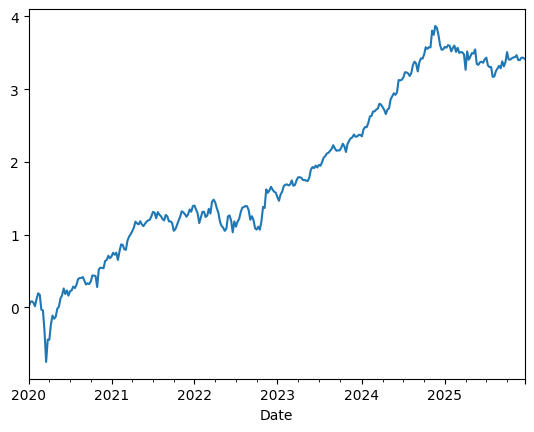

In [22]:
sp.plot()